### Image Style Transfer

![alt text](https://bloglunit.files.wordpress.com/2017/04/e18489e185b3e1848fe185b3e18485e185b5e186abe18489e185a3e186ba-2017-05-16-e1848be185a9e18492e185ae-1-50-07.png)

- A Neural Algorithm of Artistic Style (https://arxiv.org/abs/1508.06576)
- Pretrained ResNet50
- Reference below
- https://discuss.pytorch.org/t/how-to-extract-features-of-an-image-from-a-trained-model/119/3
- https://github.com/leongatys/PytorchNeuralStyleTransfer

위의 그림은 Image Style Transfer의 구조이다.  
왼쪽의 Input으로 들어가는 것은 Style Image이다.  
오른쪽의 Input으로 들어가는 것은 Content Image이다.  

이번 Model에서의 핵심은 **이전까지의 CNN은 최종 Feature Map을 통하여 Classifier를 통하여 Label을 선택하는 Model**이였다.  
하지만 **Image Style Transfer는 RNN의 Embedding의 개념과 같이 Input 을 통하여 나오는 Feature Map이 Image를 대표하는 특성을 가지고 있다면 이러한 Feature를 섞어서 Image를 복원하는 작업**을 하는 것 이다.  

현재 논문은 각각의 3개의 Network를 통하여 Style, Content, Reconstruct를 하는 Network로 구성하고 이루워 진다.  

각각의 Reconsture결과는 아래 그림과 같다.  
<img src="http://sanghyukchun.github.io/images/post/92-5.png" height="100%" width="100%" />

위의 그림에서 중요한 정보는 2가지 이다.  
1. Style reconstruction에서 알 수 있는 것은 Layer가 얕을수록 원래 content정보는 거의 무시하고 'texture'를 복원한다.
2. Layer가 깊어질수록 Content의 비중이 높아진다는 것을 알 수 있다.

이러한 이유는 **Style Layer는 Input Data를 Correlation을 통하여 GramMatrix로서 변환하여 대입하기 때문이다.**  

**GramMatrix**를 수식으로 표현하면 아래와 같다.  
$$G_{ij} = \begin{bmatrix} <v_1,v_1> & <v_1,v_2> & <v_1,v_3> \\ <v_2,v_1> & <v_2,v_2> & <v_2,v_3> \\ <v_3,v_1> & <v_3,v_2> & <v_3,v_3> \\ \end{bmatrix} = \begin{bmatrix} v_1 \\ v_2 \\ v_3 \end{bmatrix} \begin{bmatrix} v_1 & v_2 & v_3 \end{bmatrix}$$

위와 같은 과정을 Style Image에 적용시키면 다음 그림과 같다.

<img src="https://raw.githubusercontent.com/wjddyd66/wjddyd66.github.io/master/static/img/AI/145.PNG" height="100%" width="100%" />

위의 그림과 같이 각각의 원소의 곱으로서 나타낼 수 있으므로 Style Layer는 Correlation의 값이라고 표현할 수 있다.  

최종적인 Feature Map으로서 구성하고자하는 Image는 아래와 같은 Parameter로 정의하면 식을 쓸 수 있다.
- x: Result Image
- p: Content Image
- a: Style Image

$$x = argmax_{x} \alpha L_{content}(p,x) + \beta L_{style}(a,x)$$

즉 Loss에 관하여 Result Image가 최대화 되는 곳을 찾으므로서 Result Image를 구성할 수 있다.  

<br><br>

### Reconstruction
Style과 Content를 각각 Reconstruction하기 위한 수식을 알아보기 전에 공통적인 Parameter를 정의하고 가자.
- $S_l$: Style Input의 l번째 Layer의 Feature Map
- $P_l$: Content Input의 l번째 Layer의 Feature Map
- $F_l$: Result Input의 l번째 Layer의 Feature Map
- $x^l$: l번째 Layer에서 복원한 Image


**Content Reconstruction**  
$$L_{content}(p,x,l) = \frac{1}{2}\sum_{ij}(F_{ij}^{l}-P_{ij}^{l})^2$$
즉, p와x에 대해 각각 Feature map을 구하고 이 둘의 차이를 MSE로서 LossFunction을 선택한 것 이다.  
이에 관하여 Content Reconsturction을 한다고 가정하면 다음과 같다.  
$$x^l = argmax_{x}L_{content}(p,x,l)$$

위와 같은 식을 풀기위하여 최초의 $x^l$을 Random Image로 Initialize한다면 다음과 같다.  
$$\frac{\partial argmax_{x}L_{content}(p,x,l)}{\partial F_{ij}^l} = 
\begin{cases}
(F_{ij}^l - P_{ij}^{l})_{ij}  & \mbox{if } F_{ij}^l > 0 \\
0 & \mbox{if } F_{ij}^l < 0
\end{cases}
$$

위와 같은 식을 사용함으로써 전체 Gradient를 Back-propagation알고리즘을 사용해 간단하게 계산할 수 있다.
<br>
**Style Reconstruction**  
Style은 Content Reconsturction과 달리 위에서 언급한 Correlation부터 계산하여야 한다.  
Correlation을 계산한 Gram matrix를 식으로서 표현하면 아래와 같다.  
$$G_{ij}^l = \sum_{k}F_{ik}^{l}F_{kj}^l$$
또한 **Style Reconsturction의 경우 모든 Layer에서의 Feature Map을 사용한다. 즉 'Texture'를 표현하기 위하여 전체적인 분위기서 부터 좁은 영역의 분위기까지 모두 사용하겠다는 의미이다.**  
따라서 모든 Feature Map을 사용함으로 인하여 최종적인 Loss를 세우기 위한 추가적인 Parameter는 다음과 같다.  
- $A^l$: Style Feature Map Inner Product(Gram Vector of a) at Layer l
- $G^l$: Result Feature Map Inner Product(Gram Vector of a) at Layer l
- $N_l$: Feature Maps at Layer l
- $M_l$: Height x width of Feature Maps at Layer l

즉 위의 Parameter를 활용하여 각 레이어 l에서의 style loss는 아래와 같이 정의된다.  
$$E_l = \frac{1}{4N_l^2 M_l^2}\sum_{i,j}(G_{ij}^l-A_{ij}^l)^2$$

위의 각 Layer l에서의 Style Loss를 모두 더한 최종적인 Style Loss는 아래 식과 같다.  
$$L_{style}(a,x) = \sum_{l=0}^L w_l E_l$$

각 Layer의 Loss인 $E_l$에 대하여 미분하게 된다면 다음과 같은 식을 얻을 수 있다.
$$\frac{\partial E_l}{\partial F_{ij}^l} = 
\begin{cases}
\frac{1}{N_l^2 M_l^2}((F^l)^T(G^l - A^l))_{ji}  & \mbox{if } F_{ij}^l > 0 \\
0 & \mbox{if } F_{ij}^l < 0
\end{cases}
$$
<br>

**Total Loss**  
위의 Content Reconstruction에서 정리한 식과 Style Reconsturction에서 정리한 식을 통하여 전체적인 Loss를 구하게 된다면 식은 아래와 같다.  
$$L_{total}(p,a,x) = \alpha L_{content}(p,x) + \beta L_{style}(a,x)$$
위의 식에서 $\alpha, \beta$의 가중치의 적용을 어떻게 하냐에 따라서 다음과 같은 결과물을 얻을 수 있다.  
<img src="https://www.popit.kr/wp-content/uploads/2018/05/gatys_weighting_factor_for_loss.png" height="100%" width="100%" />

### Model 구현

#### 1. Settings
##### 1) Import required libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils
import torch.utils.data as data
import torchvision.models as models
import torchvision.utils as v_utils
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

##### 2) Hyperparameter

In [2]:
# 컨텐츠 손실을 어느 지점에서 맞출것인지 지정해놓습니다.
content_layer_num = 2
image_size = 512
epoch = 10000

#### 2. Data
##### 1) Directory

In [3]:
content_dir = "./image/content/1.JPG"
style_dir = "./image/style/2.jpg"

##### 2) Prepocessing Function
- 전처리 함수
- 이미 학습된 ResNet Model은 ImageNet으로 학습된 Model이기 때문에 이에 따라 정규화가 필요하다.

**즉, Input Image로 들어가는 값이 0 ~ 1사이의 값을 가지게 하기 위해서 사용하는 것 이다.**  
<a href="https://pytorch.org/docs/stable/torchvision/models.html">Pytorch 정식 Site</a>에 Pre-Trained Model 사용방법에는 권고사항으로 적혀있다.
>All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. You can use the following transform to normalize:  
<code>normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])</code>
<br>

**Normalization 식**
$$y = \frac{x-m}{\alpha}$$

In [4]:
# 이미 학습된 ResNet 모델이 이미지넷으로 학습된 모델이기 때문에 이에 따라 정규화해줍니다.
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def image_preprocess(img_dir):
    img = Image.open(img_dir)
    transform = transforms.Compose([
                    transforms.Resize(image_size),
                    transforms.CenterCrop(image_size),
                    transforms.ToTensor(),
                    normalize,
                ])
    img = transform(img).view((-1,3,image_size,image_size))
    return img

##### 3) Post processing Function
- 후처리 함수
- 위에서 Input Image를 정규화 상태로 진행하였기 때문에 원본 Image를 보기 뒤해서는 뺏던 값들을 다시 더해주는 과정이 필요하다.

위에서 Normalization 식 $y = \frac{x-m}{\alpha}$을 통하여 나타내었다.  
이러한 식을 다시 원상복구 시키기 위한 작업이 필요하다.  
$$y = \frac{x-m}{\alpha}$$
$$\alpha y = x-m$$
$$x = \alpha(y+\frac{m}{\alpha})$$

따라서 위에서 mean = $m$, std = $\alpha$로 정의하였으므로 되돌리기 위해서는  
$$mean = -\frac{m}{\alpha}, std = \frac{1}{\alpha}$$
이 되어야 한다.

**img.clamp(0,1)**  
```python
function clamp(x, min, max):
    if (x < min) then
        x = min;
    else if (x > max) then
        x = max;
    return x;
end clamp
```
즉 img의 값을 0 ~ 1 사이로 변화 시키는 것 이다.  
<br>
**torch.transpose**  
torch.transpose(input, dim0, dim1) → Tensor
즉 img의 dimension을 바꾸는 작업이다. 현재 Tensor로서 되어있는 값을 0 -> 1 ->2차원으로 늘려서 img를 볼 수 있게 구성하는 작업이다.

In [5]:
# 정규화 된 상태로 연산을 진행하고 다시 이미지화 해서 보기위해 뺐던 값들을 다시 더해줍니다.
# 또한 이미지가 0에서 1사이의 값을 가지게 해줍니다.

def image_postprocess(tensor):
    transform = transforms.Normalize(mean=[-(0.485/0.229), -(0.456/0.224), -(0.406/0.225)], std=[(1/0.229), (1/0.224), (1/0.225)])
    img = transform(tensor.clone())
    img = img.clamp(0,1)
    img = torch.transpose(img,0,1)
    img = torch.transpose(img,1,2)
    return img

#### 3. Model & Loss Function
##### 1) Resnet
<code>resnet.named_children()</code>을 통하여 ResNet Model의 직속 자식 Node들을 불러올 수 있다.

In [6]:
# 미리 학습된 resnet50를 사용합니다.
resnet = models.resnet50(pretrained=True)
for name,module in resnet.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


##### 2) Delete Fully Connected Layer

resnet.childern()으로서 자식 Node들을 불러오되 이름은 빼고 Module만 불러온다.  
Module안에는 변수들이 포함되어 있다.  
이때 리턴되는 값은 **Generator이기 때문에 이를 리스트로 바꿔주고, 사용할 Node를 Indexing을 통하여 가져온다.**  
**nn.Sequential()에 전달하기 위해서는 List가 아닌 List의 내용물을 전달해야 하기 때문에 * 을 붙여서 Unpacking작업을 한다.**

**Generator**  
 generator 는 간단하게 설명하면 iterator 를 생성해 주는 function 이다. iterator 는 next() 메소드를 이용해 데이터에 순차적으로 접근이 가능한 object 이다. iterator 에 대한 자세한 설명은 링크에서 확인. (<a href="https://bluese05.tistory.com/55">iterable 과 iterator 의 의미</a>)  
출처: <a href="https://bluese05.tistory.com/56">bluese05 블로그</a>  

**Unpacking**  
컬렉션의 요소를 여러 개의 변수에 나누어 담는 방법을 언패킹(unpacking, 풀기)이라고 부른다.

In [7]:
# 레이어마다 결과값을 가져올 수 있게 forward를 정의합니다.

class Resnet(nn.Module):
    def __init__(self):
        super(Resnet,self).__init__()
        self.layer0 = nn.Sequential(*list(resnet.children())[0:1])
        self.layer1 = nn.Sequential(*list(resnet.children())[1:4])
        self.layer2 = nn.Sequential(*list(resnet.children())[4:5])
        self.layer3 = nn.Sequential(*list(resnet.children())[5:6])
        self.layer4 = nn.Sequential(*list(resnet.children())[6:7])
        self.layer5 = nn.Sequential(*list(resnet.children())[7:8])

    def forward(self,x):
        out_0 = self.layer0(x)
        out_1 = self.layer1(out_0)
        out_2 = self.layer2(out_1)
        out_3 = self.layer3(out_2)
        out_4 = self.layer4(out_3)
        out_5 = self.layer5(out_4)
        return out_0, out_1, out_2, out_3, out_4, out_5

##### 3) Gram Matrix Function

**GramMatrix**를 수식으로 표현하면 아래와 같다.  
$$G_{ij} = \begin{bmatrix} <v_1,v_1> & <v_1,v_2> & <v_1,v_3> \\ <v_2,v_1> & <v_2,v_2> & <v_2,v_3> \\ <v_3,v_1> & <v_3,v_2> & <v_3,v_3> \\ \end{bmatrix} = \begin{bmatrix} v_1 \\ v_2 \\ v_3 \end{bmatrix} \begin{bmatrix} v_1 & v_2 & v_3 \end{bmatrix}$$

위와 같은 과정을 Style Image에 적용시키면 다음 그림과 같다.

<img src="https://raw.githubusercontent.com/wjddyd66/wjddyd66.github.io/master/static/img/AI/145.PNG" height="100%" width="100%" />

In [8]:
# 그람 행렬을 생성하는 클래스 및 함수를 정의합니다. 
# [batch,channel,height,width] -> [b,c,h*w]
# [b,c,h*w] x [b,h*w,c] = [b,c,c]

class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2)) 
        return G

##### 4) Model on GPU
**Pre Trainned된 Resnet Parameter를 변화시키지 않기 위하여 resnet의 parameter전부를 바꾸지 않는 작업이다.**  
<code>param.requires_grad = False</code>을 통하여 Parameter가 변하는 것을 방지한다.

In [9]:
# 모델을 학습의 대상이 아니기 때문에 requires_grad를 False로 설정합니다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

resnet = Resnet().to(device)
for param in resnet.parameters():
    param.requires_grad = False

cuda:0


##### 5) Gram Matrix Loss

**Style Image는 GramMatrix로 변환 후 Loss를 계산해야 하므로 따로 정의하였다.**

In [10]:
# 그람행렬간의 손실을 계산하는 클래스 및 함수를 정의합니다.

class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        return out

#### 4. Train
##### 1) Prepare Images

똑같이 ResNet을 사용하나 Style과 Content는 Weight Update가 필요 없다.  
그렇기 때문에 <code>.to(device)</code>로서 올리게 된다.  
하지만 generated 즉, Style 과 Content를 합쳐서 결과물을 낼 것은 지속적인 Weight Update가 필요하기 때문에 <code>requires_grad()</code>를 통하여 Weight가 Update가 될 수 있게 바꾼다음 Device에 올리는 작업을 실시한다.

False False True


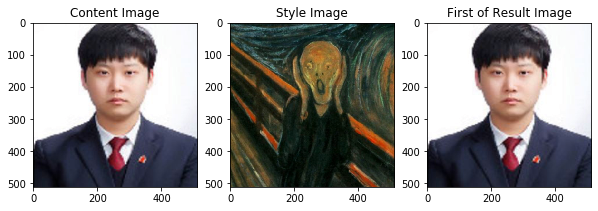

In [25]:
# 컨텐츠 이미지, 스타일 이미지, 학습의 대상이 되는 이미지를 정의합니다.

content = image_preprocess(content_dir).to(device)
style = image_preprocess(style_dir).to(device)
generated = content.clone().requires_grad_().to(device)

print(content.requires_grad,style.requires_grad,generated.requires_grad)

# 각각을 시각화 합니다.
plt.figure(figsize=(10,10))
content_image = plt.subplot(1,3,1)
content_image.set_title('Content Image')
plt.imshow(image_postprocess(content[0].cpu()))

style_image = plt.subplot(1,3,2)
style_image.set_title('Style Image')
plt.imshow(image_postprocess(style[0].cpu()))

result_image = plt.subplot(1,3,3)
gen_img = image_postprocess(generated[0].cpu()).data.numpy()
result_image.set_title('First of Result Image')
plt.imshow(gen_img)
plt.show()

##### 2) Set Targets & Style Weights
- style_target: Correlation으로서 GramMatrix를 사용하여 나타내고 모든 요소에서 뽑아내므로 Target은 for구문으로서 List로 연결
- content_target: 특정 Layer의 결과값만 사용하므 resnet의 특정 Output 1개만을 사용한다.
- style_weight: $L_{style}(a,x) = \sum_{l=0}^L w_l E_l$에서 $w_l$의 초기값을 설정하는 것 이다. Resnet Model에서 6개의 out_0 ~ out_6을 뽑아내므로 6개 선언

In [12]:
# 목표값을 설정하고 행렬의 크기에 따른 가중치도 함께 정의해놓습니다

style_target = list(GramMatrix().to(device)(i) for i in resnet(style))
content_target = resnet(content)[content_layer_num]
style_weight = [1/n**2 for n in [64,64,256,512,1024,2048]]

##### 3) Train

- style_loss: $L_{style}(a,x)$
- content_loss: $L_{content}(p,x)$
- total_loss: $L_{total}(p,a,x) = \alpha L_{content}(p,x) + \beta L_{style}(a,x)$  

Optimizer로서는 처음보는 LBFGS를 사용하였다.  
**<code>torch.optim.LBFGS(params, lr=1, max_iter=20, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100, line_search_fn=None)</code>**  

- lr (float) – learning rate (default: 1)

- max_iter (int) – maximal number of iterations per optimization step (default: 20)

- max_eval (int) – maximal number of function evaluations per optimization step (default: max_iter * 1.25).

- tolerance_grad (float) – termination tolerance on first order optimality (default: 1e-5).

- tolerance_change (float) – termination tolerance on function value/parameter changes (default: 1e-9).

- history_size (int) – update history size (default: 100).

- line_search_fn (str) – either ‘strong_wolfe’ or None (default: None).

<br>

LBFGS에 기본이 되는 Newton's Method부터 살펴보자.  
<br>
**Newton's Method**  

<img alt="" src="//upload.wikimedia.org/wikipedia/commons/thumb/e/e0/NewtonIteration_Ani.gif/300px-NewtonIteration_Ani.gif" decoding="async" width="300" height="214" class="thumbimage" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/e/e0/NewtonIteration_Ani.gif/450px-NewtonIteration_Ani.gif 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/e/e0/NewtonIteration_Ani.gif/600px-NewtonIteration_Ani.gif 2x" data-file-width="673" data-file-height="480">

Newton's Method는 위의 그림과 같다.  
결론 부터 얘기하자면  
어떤 $x$에 대한 함수 $f(x)$가 존재한다고 가정하자.  
$f(x) = 0$인점을 찾는 것이 목적이다.  
이러한 목적을 위해서 한 점 $x_t$에서의 값을 $f(x_t)$라고 한다면  
$f\prime(x_t)$와 x축과의 접점을 $x_{t+1}$이라고 하자  
그렇다면 식은 아래와 같이 적용 될 수 있다.  
$$f\prime(x_t) = \frac{f(x_t)-0}{x_t-x_{t+1}}$$
$$x_t - x_{t+1} = \frac{f(x_t)}{f\prime(x_t)}$$
$$x_{t+1} = x_t - \frac{f(x_t)}{f\prime(x_t)}$$

위의 식의 과정을 아래와 같은 식에 다시 적용시킨다고 하면  
$$f\prime\prime(x_t) = \frac{f\prime(x_t)-0}{x_t-x_{t+1}}$$
$$x_t - x_{t+1} = \frac{f\prime(x_t)}{f\prime\prime(x_t)}$$
$$x_{t+1} = x_t - \frac{f\prime(x_t)}{f\prime\prime(x_t)}$$

즉 계속 반복하다 보면 $f\prime(x_t) = 0$인 지점 찾을 수 있다는 방식이 **Newton's Method**이다.  

위와 같이 2차 미분 값을 얻기 위한 $f\prime\prime(x_t)$는 시간이 $O(n^3)$이나 걸리므로 이 값을 근사하는 방식으로 바꿔서 연산 속도를 높인 방식이 바로 **BFGS**이다.  
**BFGS**에서 최근 m개의 1차 미분 값만을 사용해서 더 적은 메모리를 사용하게 변형한 방법이 바로 **L-BFGS**이다.  
 
<a href="https://www.cs.ubc.ca/~schmidtm/Software/minFunc.html">L-BGFS 자세한 내용</a>

In [13]:
# LBFGS 최적화 함수를 사용합니다.
# 이때 학습의 대상은 모델의 가중치가 아닌 이미지 자체입니다.

optimizer = optim.LBFGS([generated])

iteration = [0]
while iteration[0] < epoch:
    def closure():
        optimizer.zero_grad()
        out = resnet(generated)
        
        # 스타일 손실을 각각의 목표값에 따라 계산하고 이를 리스트로 저장합니다.
        style_loss = [GramMSELoss().to(device)(out[i],style_target[i])*style_weight[i] for i in range(len(style_target))]
        
        # 컨텐츠 손실은 지정한 위치에서만 계산되므로 하나의 수치로 저장됩니다.
        content_loss = nn.MSELoss().to(device)(out[content_layer_num],content_target)
        
        # 스타일:컨텐츠 = 10:1의 비중으로 총 손실을 계산합니다.
        total_loss = 10 * sum(style_loss) + torch.sum(content_loss)
        total_loss.backward()

        if iteration[0] % 100 == 0:
            print(total_loss)
        iteration[0] += 1
        return total_loss

    optimizer.step(closure)

tensor(22277024., device='cuda:0', grad_fn=<AddBackward0>)
tensor(197.4590, device='cuda:0', grad_fn=<AddBackward0>)
tensor(134.6795, device='cuda:0', grad_fn=<AddBackward0>)
tensor(99.0320, device='cuda:0', grad_fn=<AddBackward0>)
tensor(69.0277, device='cuda:0', grad_fn=<AddBackward0>)
tensor(41.5575, device='cuda:0', grad_fn=<AddBackward0>)
tensor(22.1648, device='cuda:0', grad_fn=<AddBackward0>)
tensor(12.2483, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.6979, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.4991, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.3654, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.6235, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.0960, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.7097, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.3853, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0800, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7934, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5684, device='cuda:0', grad

#### 5. Check Results

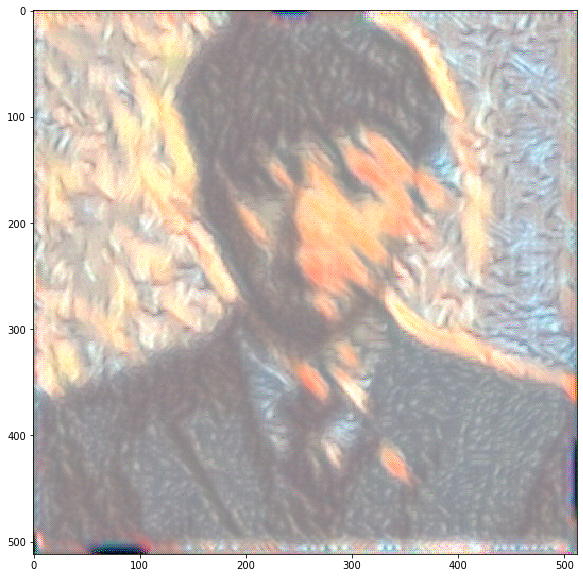

In [14]:
# 학습된 결과 이미지를 확인합니다.

gen_img = image_postprocess(generated[0].cpu()).data.numpy()

plt.figure(figsize=(10,10))
plt.imshow(gen_img)
plt.show()